`einsum`

In [ ]:
import torch.nn as nn
import torch

A = torch.randn(3,4,5)
#i = 3 , j = 4, k = 5

B = torch.randn(3,4)
C = torch.randn(3,4)

res = torch.einsum("ij,ij -> i",B,C) #运算B*C并对j列求和

print(res,res.shape)

D = torch.randn(3,4)

res2 = torch.einsum('ij ->i',A)#对每行求和

# 自动保留所有不重复的字母
torch.einsum('ij,jk', A, B)  
# 等价于 'ij,jk->ik'（矩阵乘法）

tensor([-1.8321, -0.1107,  0.1705]) torch.Size([3])


In [6]:
#计算batch中每对向量的点积

import torch

# 输入
A = torch.randn(32, 128)  # [batch=32, dim=128]
B = torch.randn(32, 128)  # [batch=32, dim=128]

# 目标：计算每个 batch 内的点积
# 期望输出 shape: [32]（每个 batch 一个标量）

# 你的代码：
result = torch.einsum('ij,ij ->i', A, B)

print(result.shape)  # 应该是 torch.Size([32])

torch.Size([32])


In [8]:
#计算 Query 和 Key 的注意力分数（简化版，无 batch 和 heads）

Q = torch.randn(10, 64)  # [seq_len_q=10, d_k=64]
K = torch.randn(15, 64)  # [seq_len_k=15, d_k=64]

# 目标：计算 Q @ K^T
# 期望输出 shape: [10, 15]
# scores[i,j] = Q[i, :] · K[j, :]（第 i 个 query 和第 j 个 key 的点积）

# 你的代码：
scores = torch.einsum('ik,jk ->ij ', Q, K)

print(scores.shape)  # 应该是 torch.Size([10, 15])

# 验证（可选）
expected = Q @ K.T
print(torch.allclose(scores, expected))  # 应该是 True

torch.Size([10, 15])
True


### 归一化层(Normalization)

我们用RMSNorm来替代LayerNorm。RMSNorm的公式如下：

$$\text{RMSNorm}(x) = \frac{x}{\text{RMS}(x)} \cdot \gamma$$

其中均方根的计算公式如下：
$$\text{RMS}(x) = \sqrt{\frac{1}{d} \sum_{i=1}^{d} x_i^2 + \epsilon}$$

- gamma (权重): 形状 (d_model,)，初始化为 1
- eps: 防止除零的小常数
- RMS 计算: 对最后一个维度求均方根
- 没有 beta: 和 LayerNorm 不同，RMSNorm 没有偏移项

### 前馈网络(FFN)
原始Transformer中的前馈网络由两个线性层和一个ReLU激活函数组成，内层前馈层的维度通常是输入维度的4倍。

然而，现代大语言模型广泛采用另一种激活函数，并引入门控机制(gating mechanism)，这就是SwiGLU激活函数。

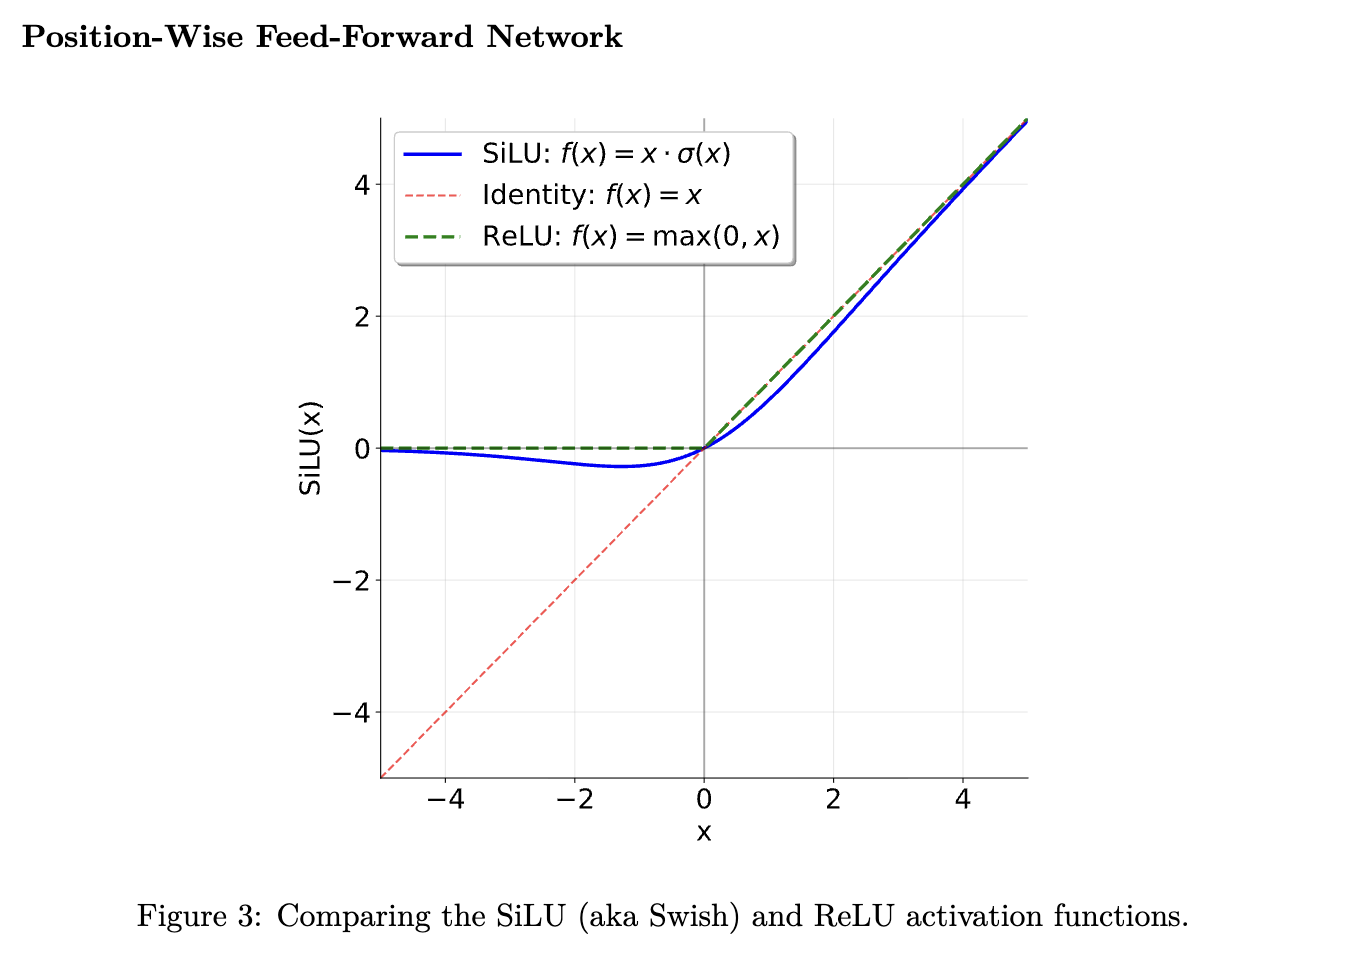

#### 门控机制(GLU)

传统激活
```
output = activation(x @ W)
```

门控机制
```sh
gate = σ(x @ W_gate)    # 门控信号（0到1）
value = x @ W_value     # 内容信号
output = gate * value   # 门控调节内容
```

**直觉**：
- **gate**：决定"开多大门"
- **value**：决定"传递什么内容"
- 两者相乘：动态控制信息流

---

#### 🔬 SwiGLU 公式

$$
\text{SwiGLU}(x, W, V) = \text{Swish}(xW) \otimes (xV)
$$

**关键组件**：

1. **Swish 激活**（也叫 SiLU）：
   $$
   \text{Swish}(x) = x \cdot \sigma(x) = \frac{x}{1+e^{-x}}
   $$

2. **门控乘法**：
   - $xW$：通过 Swish 变成门控信号
   - $xV$：内容信号
   - 逐元素相乘 $\otimes$

---

#### 📐 完整 FFN 结构

SwiGLU 需要 **3 个线性层**：

$$
\text{FFN}(x) = (\text{Swish}(xW_1) \otimes xW_2) W_3
$$

**维度流程**：
```sh
输入: [d_model]
  ↓
  ├─→ W1 [d_model → d_ff] ─→ Swish ─→ gate [d_ff]
  │                                       ↓
  └─→ W2 [d_model → d_ff] ─────────→ value [d_ff]
                                          ↓
                            gate ⊗ value [d_ff]
                                          ↓
                            W3 [d_ff → d_model]
                                          ↓
                                    输出 [d_model]